# Assignment 3
## Part II - Practical
## Mahla Entezari

At the beginning of the project, I have imported the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
import re
from scipy.linalg import triu
from hazm import *
from hazm import Normalizer, word_tokenize, stopwords_list
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
# from farsispellchecker import SpellChecker
import stanza

In this piece of code, I take a list of stop words from the hazm library, in other words, words such as conjunctions and prepositions and frequently used words that do not affect the overall meaning and concept of the sentence and are used in most topics and are frequently used and frequently used.

In [ ]:
persian_stopwords = set(stopwords_list())
persian_stopwords

{'آخرین',
 'آقای',
 'آمد',
 'آمده',
 'آمده_است',
 'آن',
 'آنان',
 'آنجا',
 'آنها',
 'آنچه',
 'آنکه',
 'آورد',
 'آوری',
 'آیا',
 'ابتدا',
 'اثر',
 'اجرا',
 'اخیر',
 'از',
 'است',
 'اش',
 'اغلب',
 'افراد',
 'افرادی',
 'افزود',
 'البته',
 'اما',
 'امر',
 'امکان',
 'اند',
 'او',
 'اول',
 'اولین',
 'اکنون',
 'اگر',
 'ایشان',
 'این',
 'اینجا',
 'اینکه',
 'با',
 'بار',
 'باره',
 'باز',
 'باشد',
 'باشند',
 'باعث',
 'بالا',
 'باید',
 'بخش',
 'بخشی',
 'بدون',
 'بر',
 'برابر',
 'براساس',
 'برای',
 'برخی',
 'برداری',
 'بروز',
 'بزرگ',
 'بسیار',
 'بسیاری',
 'بعد',
 'بعضی',
 'بلکه',
 'بنابراین',
 'بندی',
 'به',
 'بهتر',
 'بهترین',
 'بود',
 'بودن',
 'بودند',
 'بوده',
 'بوده_است',
 'بی',
 'بیان',
 'بیرون',
 'بیش',
 'بیشتر',
 'بیشتری',
 'بین',
 'تا',
 'تاکنون',
 'تبدیل',
 'تحت',
 'ترتیب',
 'تعداد',
 'تعیین',
 'تغییر',
 'تمام',
 'تمامی',
 'تنها',
 'تهیه',
 'تو',
 'جا',
 'جاری',
 'جای',
 'جایی',
 'جدی',
 'جدید',
 'جریان',
 'جز',
 'جمع',
 'جمعی',
 'حال',
 'حالا',
 'حالی',
 'حتی',
 'حد',
 'حداقل',
 'حدود',

Here I define functions that are called below in the preprocessing function. Functions like clean_code, normalize_text, remove_diacritics, preprocess_with_stanza, named_entity_recognition, extract_relations, spell_checker,..

- ##### *clean_text*, *normalize_text*, *remove_diacritics*
  It works in such a way that it removes prepositions such as space, normalizes it, and also removes stop words and similar tasks.\
  Or, for example, it unites letters such as ک and ی which may be written in several ways.

- ##### *preprocess_with_stanza*
  It tokenizes input text using Stanza's natural language processing tools, extracting various linguistic features such as lemma, part-of-speech tags,    dependency relations, and named entity recognition labels for each word, returning them as a list of dictionaries representing each word's features

- ##### *named_entity_recognition*
  This function utilizes Stanza to perform named entity recognition (NER) on Persian text.\
  It downloads the necessary model, processes the text through Stanza's pipeline, and prints detected entities with their types, as well as words with their syntactic dependencies (head and dependency relation).

- ##### *extract_relations*
  This function processes a Stanza doc object, extracting relations between entities in Persian text sentences.\
  It identifies potential subject, object, indirect object, and modifier relationships (nsubj, obj, iobj, amod) and includes them in relations if both the dependent and head words are recognized entities.\
  It then prints and returns a list of tuples representing these relations.

- ##### *spell_checker*
    This is designed to correct spelling in a given text.

In [ ]:
normalizer = Normalizer()
# stanza.download('fa')
# nlp = stanza.Pipeline('fa', processors='tokenize,pos,lemma,depparse,ner')
# spell_checker = SpellChecker()

def clean_text(text):

    if isinstance(text, str):

        text = re.sub(r'[^آ-ی\s]', '', text)

        text = normalizer.normalize(text)

        text = re.sub(r'\s+', ' ', text).strip()

        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = text.lower()

        tokens = word_tokenize(text)

        tokens = [token for token in tokens if token not in persian_stopwords]

        return ' '.join(tokens)
    else:
        return ''

def normalize_text(text):
    text = text.replace('ك', 'ک').replace('ي', 'ی')
    text = text.translate(str.maketrans('0123456789', '۰۱۲۳۴۵۶۷۸۹'))
    return text

def remove_diacritics(text):
    diacritics = re.compile("[\u064B-\u0652]")
    text = re.sub(diacritics, '', text)
    return text

def preprocess_with_stanza(text):
    doc = nlp(text)
    processed_text = []
    for sentence in doc.sentences:
        for word in sentence.words:
            processed_text.append({
                'text': word.text,
                'lemma': word.lemma,
                'upos': word.upos,
                'xpos': word.xpos,
                'head': word.head,
                'deprel': word.deprel,
                'ner': word.ner,
            })
    return processed_text


def named_entity_recognition(text):
    stanza.download('fa')
    nlp = stanza.Pipeline('fa')
    doc = nlp(text)
    for sentence in doc.sentences:
        for entity in sentence.ents:
            print(f"Entity: {entity.text}, Type: {entity.type}")

        for word in sentence.words:
            print(f"Word: {word.text}, Head: {word.head}, Deprel: {word.deprel}")

def extract_relations(doc):
    relations = []
    for sentence in doc.sentences:
        entities = [(entity.text, entity.type) for entity in sentence.ents]
        if len(entities) < 2:
            continue

        for word in sentence.words:
            if word.deprel in ["nsubj", "obj", "iobj", "amod"]:
                head_word = sentence.words[word.head - 1]
                if head_word.ner != "O" and word.ner != "O":
                    relations.append((head_word.text, word.text, word.deprel))

    for relation in relations:
        print(f"Relation: {relation}")
    return relations

def spell_checker(text):
    tokens = text.split()
    corrected_text = []
    for token in tokens:
        corrected_token = spell_checker.correct(token)
        corrected_text.append(corrected_token)

    corrected_sentence = ' '.join(corrected_text)
    return corrected_sentence

In [ ]:
# import nlpaug.augmenter.word as naw
# def augment_text(text, aug_type='synonym'):
#     augmenter = naw.SynonymAug(aug_src='wordnet')
#     augmented_text = augmenter.augment(text)
#     return augmented_text

In [ ]:
def data_preproccess(df):
    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_text'] = df['cleaned_text'].apply(normalize_text)
    df['cleaned_text'] = df['cleaned_text'].apply(remove_diacritics)
    # df['cleaned_text'] = df['cleaned_text'].apply(preprocess_with_stanza)
    # df['cleaned_text'] = df['cleaned_text'].apply(named_entity_recognition)
    # df['cleaned_text'] = df['cleaned_text'].apply(spell_checker)
    # df['cleaned_text'] = df['cleaned_text'].apply(augment_text)
    return df


In [ ]:
df = pd.read_csv('train_data.csv')
df

,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
0,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
1,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
2,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
3,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD
...,...,...
4918,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY
4919,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD
4920,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD
4921,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER


At this stage, instead of manipulating the data and adding a line above the rest of the lines
I created two new columns, one of which is the text column and the other is the label column.

In [ ]:
df['text']=df.iloc[:,0]
df['label']=df.iloc[:,1]

Encode categorical labels (df['label']) into numerical values suitable for machine learning algorithms.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])

train, test = train_test_split(X_bow, test_size=0.05, random_state=42)
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']


In [ ]:
text = "۱۲۳ امتحان می‌کنیم"
cleaned_tokens = clean_text(text)
print(cleaned_tokens)

امتحان میکنیم


In [ ]:
X_train = data_preproccess(X_train)
df

,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD,text,label,cleaned_text
0,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER,عکسی روز گذاشته_بودم فیلم الانشه وسط کوهها لاب...
1,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD,تنهاییم شبیه تنهاییه ظهرای بچگیم وقتیکه میخواب...
2,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY,خوبه قسمتهای گوشی محافظت میکنه
3,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY,خاکمال مردمان حاکمان ایران مهساامینی
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD,اگه بغلت بودم حالم میشد
...,...,...,...,...,...
4918,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY,بو ماندگاریش راضی بودم قیمتش مناسبه
4919,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...
4920,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD,بهم برنو عاشق نمیشی گفتم پول عاشقی کردنو نداری...
4921,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER,قضیهی گاز میپردازیم فراخوان مهساامینی


In [ ]:
from collections import Counter

word_counts = Counter()
for text in X_train['cleaned_text']:
    tokens = text.split()
    word_counts.update(tokens)
word_counts

Counter({'مهساامینی': 445,
         'گاز': 347,
         'دوست': 264,
         'زلزله': 257,
         'یه': 238,
         'داره': 229,
         'سال': 189,
         'عالیه': 187,
         'واقعا': 178,
         'میکنم': 173,
         'خوبه': 166,
         'دارم': 166,
         'اصلا': 145,
         'سیل': 140,
         'پیشنهاد': 140,
         'میشه': 140,
         'دیگه': 134,
         'کیفیت': 130,
         'عشق': 129,
         'هست': 125,
         'ایران': 124,
         'نداره': 112,
         'مردم': 111,
         'خریدم': 109,
         'الان': 103,
         'باشه': 103,
         'کرونا': 101,
         'میکنه': 92,
         'خرید': 90,
         'بورس': 90,
         'قیمت': 90,
         'روز': 81,
         'قیمتش': 81,
         'راضی': 79,
         'اگه': 77,
         'استفاده': 77,
         'برد': 77,
         'چی': 76,
         'اون': 74,
         'حتما': 74,
         'کار': 72,
         'راضیم': 71,
         'میترسم': 70,
         'ارزش': 69,
         'کاش': 69,
         'درد': 67

Here we count the number of types of words and the number of times each word appears
Then, for a better and more practical view, we keep the words that have been repeated at least 100 times and then sort them.

In [ ]:
filtered_word_counts = {word: freq for word, freq in word_counts.items() if freq >= 100}
filtered_word_counts = dict(sorted(filtered_word_counts.items(), key=lambda item: item[1], reverse=True))
filtered_word_counts

{'مهساامینی': 445,
 'گاز': 347,
 'دوست': 264,
 'زلزله': 257,
 'یه': 238,
 'داره': 229,
 'سال': 189,
 'عالیه': 187,
 'واقعا': 178,
 'میکنم': 173,
 'خوبه': 166,
 'دارم': 166,
 'اصلا': 145,
 'سیل': 140,
 'پیشنهاد': 140,
 'میشه': 140,
 'دیگه': 134,
 'کیفیت': 130,
 'عشق': 129,
 'هست': 125,
 'ایران': 124,
 'نداره': 112,
 'مردم': 111,
 'خریدم': 109,
 'الان': 103,
 'باشه': 103,
 'کرونا': 101}

Here we count the number of types of words and the number of times each word appears
Then, for a better and more practical view, we keep the words that have been repeated at least 100 times and then sort them.

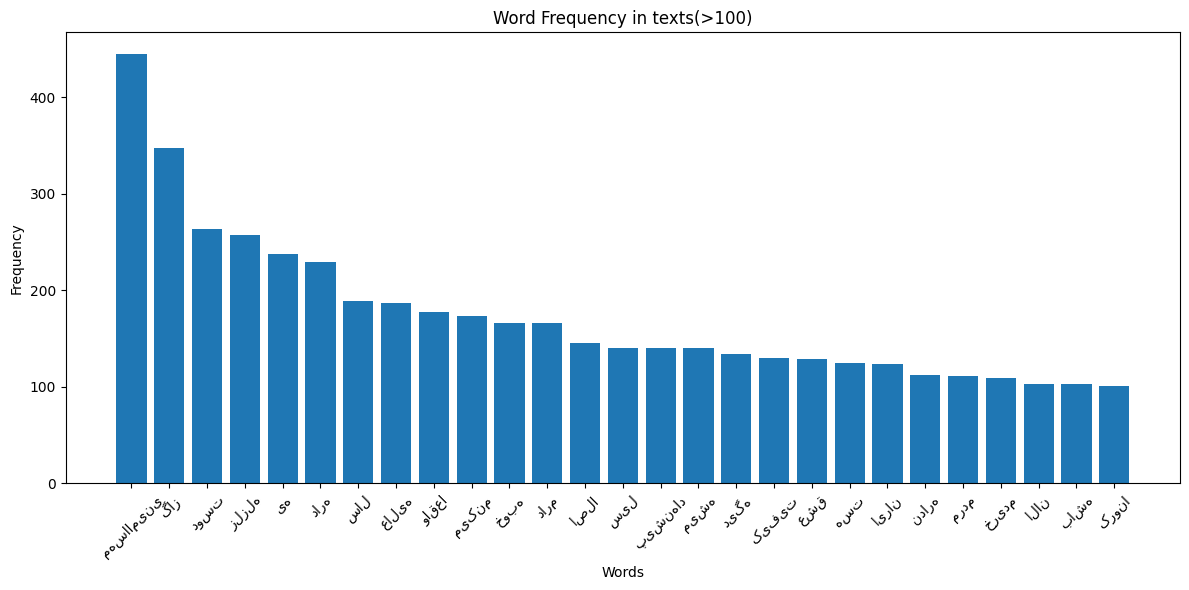

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(filtered_word_counts.keys(), filtered_word_counts.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency in texts(>100)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Also, according to this graph, it is clear that most of the texts have the **happy** label
And also the lowest number of that **Fear** label

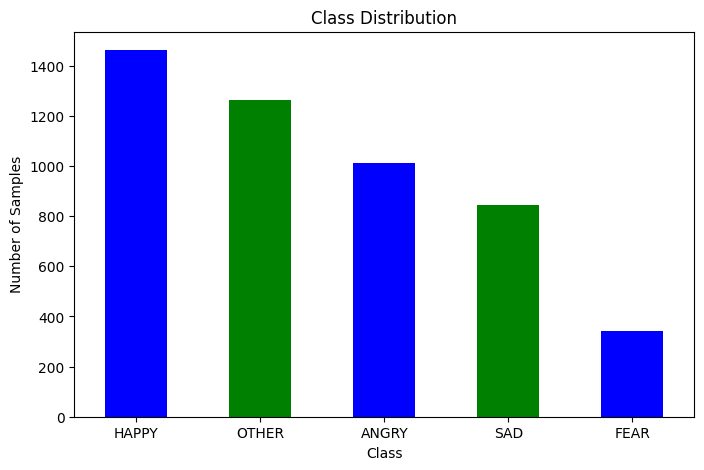

In [ ]:
class_dist = train['label'].value_counts()

plt.figure(figsize=(8, 5))
class_dist.plot(kind='bar', color=['blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.show()


In [ ]:
bow = CountVectorizer()
X_bow = bow.fit_transform(X_train['cleaned_text'])
X_bow

<4923x10369 sparse matrix of type '<class 'numpy.int64'>'
	with 33868 stored elements in Compressed Sparse Row format>

In [ ]:
#    the  quick  brown  fox  jumps  over  lazy  dog  blue  sleeps
# 1   2      1      1    1      1     1     1     1     0       0
# 2   1      1      0    1      0     0     0     0     1       0
# 3   1      0      0    0      0     0     1     1     0       1


CountVectorizer (bow): Counts how often each word appears in each document.

TfidfVectorizer (tfidf): Measures how important each word is to a document compared to the entire collection, accounting for word frequency and rarity across documents.

In [ ]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train['cleaned_text'])
X_tfidf

<4923x10369 sparse matrix of type '<class 'numpy.float64'>'
	with 33868 stored elements in Compressed Sparse Row format>

In [ ]:
# [[0.         0.23109072 0.30821133 0.23109072 0.30821133 0.30821133 0.23109072 0.23109072 0.         0.        ]
#  [0.         0.45018777 0.         0.45018777 0.         0.         0.         0.         0.63245449 0.        ]
#  [0.         0.         0.         0.         0.         0.         0.41745632 0.41745632 0.         0.54645449]]

# ['blue', 'brown', 'dog', 'fox', 'jumps', 'lazy', 'over', 'quick', 'sleeps', 'the']


Then, from here on, I will train several different models on the data to compare their efficiency

These models include

*Decision tree*, *Random forest*, *GradientBoosting*, *LogisticRegression*, *MultinomialNB* and *XGBoost*

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print(classification_report(y_test, dt_pred))


Decision Tree Accuracy: 0.5425101214574899
              precision    recall  f1-score   support

           0       0.47      0.42      0.44        53
           1       0.47      0.47      0.47        15
           2       0.77      0.63      0.70        76
           3       0.46      0.57      0.51        69
           4       0.47      0.53      0.50        34

    accuracy                           0.54       247
   macro avg       0.53      0.52      0.52       247
weighted avg       0.56      0.54      0.55       247



In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.5870445344129555
              precision    recall  f1-score   support

           0       0.70      0.36      0.47        53
           1       0.83      0.33      0.48        15
           2       0.78      0.70      0.74        76
           3       0.45      0.84      0.59        69
           4       0.59      0.29      0.39        34

    accuracy                           0.59       247
   macro avg       0.67      0.50      0.53       247
weighted avg       0.65      0.59      0.57       247



In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_model.fit(X_train, y_train)

gb_preds = gb_model.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_preds))
print(classification_report(y_test, gb_preds))

Gradient Boosting Accuracy: 0.5910931174089069
              precision    recall  f1-score   support

           0       0.81      0.40      0.53        53
           1       0.47      0.60      0.53        15
           2       0.84      0.61      0.70        76
           3       0.46      0.78      0.58        69
           4       0.53      0.47      0.50        34

    accuracy                           0.59       247
   macro avg       0.62      0.57      0.57       247
weighted avg       0.66      0.59      0.59       247



In [ ]:
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='hard')
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Accuracy:", accuracy)

Ensemble Model Accuracy: 0.5991902834008097


In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

Accuracy: 0.6194331983805668
              precision    recall  f1-score   support

           0       0.65      0.57      0.61        53
           1       0.50      0.33      0.40        15
           2       0.81      0.72      0.76        76
           3       0.50      0.62      0.55        69
           4       0.54      0.59      0.56        34

    accuracy                           0.62       247
   macro avg       0.60      0.57      0.58       247
weighted avg       0.63      0.62      0.62       247



In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'max_depth': 3,
    'objective': 'multi:softmax',
    'num_class': len(encoder.classes_),
    'eval_metric': 'merror'
}

num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_boost_round=num_rounds)
xgb_preds = xgb_model.predict(dtest)

decoded_preds = encoder.inverse_transform(xgb_preds.astype(int))

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds, target_names=encoder.classes_))

XGBoost Accuracy: 0.5910931174089069
              precision    recall  f1-score   support

       ANGRY       0.74      0.49      0.59        53
        FEAR       0.54      0.47      0.50        15
       HAPPY       0.84      0.62      0.71        76
       OTHER       0.44      0.72      0.55        69
         SAD       0.53      0.47      0.50        34

    accuracy                           0.59       247
   macro avg       0.62      0.55      0.57       247
weighted avg       0.65      0.59      0.60       247



In [ ]:
params = {
    'objective': 'multi:softmax',
    'num_class': len(encoder.classes_),
    'eval_metric': 'merror',
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}
num_rounds = 100
nfold = 5
early_stopping_rounds = 20

cv_results = xgb.cv(params, dtrain, num_rounds, nfold=nfold, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
best_num_rounds = len(cv_results)
final_model = xgb.train(params, dtrain, best_num_rounds)
xgb_preds = final_model.predict(dtest)

decoded_preds = encoder.inverse_transform(xgb_preds.astype(int))

print("Best num rounds XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds, target_names=encoder.classes_))

[0]	train-merror:0.53903+0.00767	test-merror:0.55945+0.00882
[1]	train-merror:0.50235+0.00461	test-merror:0.53379+0.01561
[2]	train-merror:0.48182+0.00358	test-merror:0.51283+0.01355
[3]	train-merror:0.46931+0.00400	test-merror:0.50428+0.01206
[4]	train-merror:0.45707+0.00249	test-merror:0.49123+0.00755
[5]	train-merror:0.45113+0.00299	test-merror:0.49017+0.00740
[6]	train-merror:0.44392+0.00430	test-merror:0.48567+0.00625
[7]	train-merror:0.44033+0.00417	test-merror:0.48332+0.00653
[8]	train-merror:0.43472+0.00442	test-merror:0.48097+0.00653
[9]	train-merror:0.43087+0.00452	test-merror:0.47947+0.00566
[10]	train-merror:0.42820+0.00462	test-merror:0.47733+0.00575
[11]	train-merror:0.42387+0.00373	test-merror:0.47434+0.00507
[12]	train-merror:0.41836+0.00425	test-merror:0.47391+0.00440
[13]	train-merror:0.41333+0.00507	test-merror:0.47199+0.00293
[14]	train-merror:0.40948+0.00383	test-merror:0.47092+0.00366
[15]	train-merror:0.40441+0.00424	test-merror:0.46749+0.00295
[16]	train-merror:

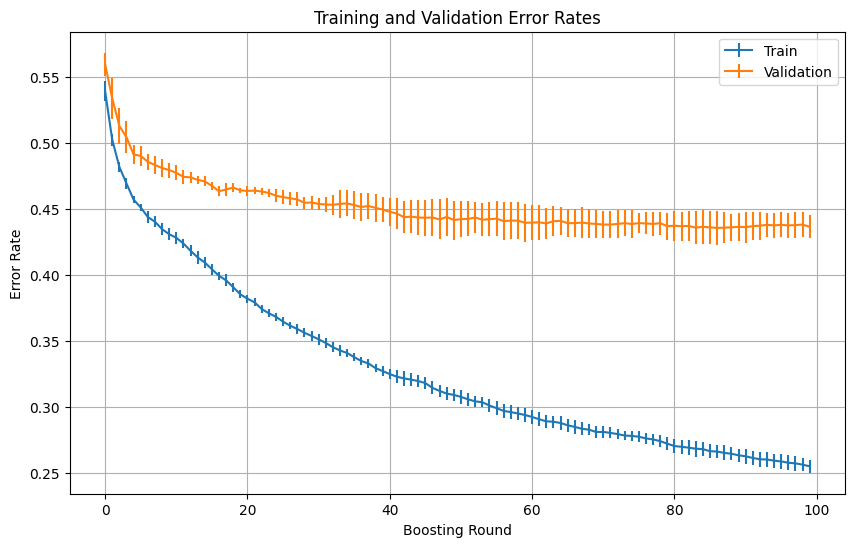

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(cv_results.index, cv_results['train-merror-mean'], yerr=cv_results['train-merror-std'], label='Train')
plt.errorbar(cv_results.index, cv_results['test-merror-mean'], yerr=cv_results['test-merror-std'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('Error Rate')
plt.title('Training and Validation Error Rates')
plt.legend()
plt.grid()
plt.show()

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.6032388663967612
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58        53
           1       0.31      0.33      0.32        15
           2       0.77      0.74      0.75        76
           3       0.53      0.59      0.56        69
           4       0.55      0.53      0.54        34

    accuracy                           0.60       247
   macro avg       0.55      0.55      0.55       247
weighted avg       0.61      0.60      0.61       247



After comparing all these models and trying to improve the efficiency and increase the accuracy percentage and change the parameters and the number of rounds\
It can be seen with a slight difference that the best of these models are the following models:

**Gradient Boosting** , **Ensemble Model**, **XGBoost** and **Multinomial Naive Bayes** with about **60%** accuracy and best of them is ***Logistic Regression*** with ***62%*** accuracy.